# DQN, Deep Q Learning

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

from collections import namedtuple, deque

In [2]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [4]:
plt.style.use('ggplot')

## Set Configs

In [5]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [6]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3 # for soft update of target parameters
LR = 5e-4
PRINT_EVERY = 100
UPDATE_EVERY = 4

## Set Environment

In [7]:
ENV_NAME = 'LunarLander-v2'
env = gym.make(ENV_NAME).unwrapped; env.seed(90);

In [8]:
print('Environment Display:')
env.reset() # reset environment to a new, random state
env.render()

print('State space {}'.format(env.observation_space))
print('Action space {}'.format(env.action_space))

Environment Display:
State space Box(8,)
Action space Discrete(4)


## Build DQN Architecture

In [9]:
class DQN(nn.Module):
    """Define DQN architecture."""
    
    def __init__(self, state_size, action_size, seed, fcl_units=64, fc2_units=64):
        """Initialize parameters and build model."""
        
        super(DQN, self).__init__()
        
        self.seed = torch.manual_seed(seed)
        
        self.fc1_layer = nn.Linear(state_size, fcl_units)
        self.fc2_layer = nn.Linear(fcl_units, fc2_units)
        self.fc3_layer = nn.Linear(fc2_units, action_size)
        
    def forward(self, state):
        """Build a network that maps state into action values."""
        
        state = F.relu(self.fc1_layer(state))
        state = F.relu(self.fc2_layer(state))
        Qsa = self.fc3_layer(state)
        
        return Qsa        

## Set Replay Buffer

In [10]:
class ReplayBuffer(object):
    """Fixed-size buffer to store experience tuples."""
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayMemory object."""
        
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to buffer."""
        
        self.memory.append(self.experience(state, action, reward, next_state, done))
        
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([exp.state for exp in experiences if exp is not None])).float()
        states = states.to(device)
        
        actions = torch.from_numpy(np.vstack([exp.action for exp in experiences if exp is not None])).long()
        actions = actions.to(device)
        
        rewards = torch.from_numpy(np.vstack([exp.reward for exp in experiences if exp is not None])).float()
        rewards = rewards.to(device)
        
        next_states = torch.from_numpy(np.vstack([exp.next_state for exp in experiences if exp is not None])).float()
        next_states = next_states.to(device)
        
        dones = torch.from_numpy(np.vstack([exp.done for exp in experiences if exp is not None]).astype(np.uint8)).float()
        dones = dones.to(device)
        
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Define DQN Agent

In [11]:
class DQNAgent():
    """The agent interacting with and learning from the environment."""
    
    def __init__(self, state_size, action_size, seed):
        """Initialize an agent object."""
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Q-Network
        self.dqn_net = DQN(state_size, action_size, seed).to(device)
        self.target_net = DQN(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.dqn_net.parameters(), lr=LR)
        
        # Replay Buffer
        self.buffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.time_step = 0
        
    def memorize(self, state, action, reward, next_state, done):
        """Save experience in replay buffer."""
        
        self.buffer.add(state, action, reward, next_state, done)
    
        self.time_step = (self.time_step + 1) % UPDATE_EVERY
        if self.time_step == 0:
            # if enough samples are available in memory, get random subset and learn
            if len(self.buffer) > BATCH_SIZE:
                experiences = self.buffer.sample()
                self.learn(experiences, GAMMA)
            
    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy."""
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.dqn_net.eval()
        with torch.no_grad():
            action_values = self.dqn_net(state)
        self.dqn_net.train()
        
        # epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples."""
    
        states, actions, rewards, next_states, dones = experiences
        
        self.optimizer.zero_grad()
        
        # get max predicted Q values (for next states) from target network
        Q_target_next = self.target_net(next_states).detach().max(1)[0].unsqueeze(1)
        
        # compute Q target
        Q_target = rewards + (gamma * Q_target_next * (1 - dones))
        
        # get expected Q values from dqn network
        Q_expected = self.dqn_net(states).gather(1, actions)
        
        # compute loss
        loss = F.mse_loss(Q_expected, Q_target)
        
        # minimize the loss
        loss.backward()
        self.optimizer.step()
        
        # update target network
        self.soft_update(self.dqn_net, self.target_net, TAU)
        
    def soft_update(self, dqn_net, target_net, tau):
        """Soft update model parameters."""
        
        for dqn_param, target_param in zip(dqn_net.parameters(), target_net.parameters()):
            target_param.data.copy_(tau*dqn_param.data + (1.0-tau) * target_param.data)

In [12]:
agent = DQNAgent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=90)

In [13]:
# watch an untrained agent
state = env.reset()
for time_step in range(200):
    
    # select an action
    action = agent.act(state)
    env.render()
    
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()

## Train The Agent

In [14]:
def train_agent(num_episodes, max_time=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Train DQN agent."""
    
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    
    for i_episode in range(1, num_episodes+1):
        state = env.reset()
        score = 0
        for time_step in range(max_time):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            
            agent.memorize(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
                
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        
        print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}', end='')
        
        if i_episode % PRINT_EVERY == 0:
            print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window) >= 200.0:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes! Average Score: {np.mean(scores_window):.2f}')
            if not os.path.exists('./agents/'): os.makedirs('./agents/')
            torch.save(agent.dqn_net.state_dict(), f'./agents/DQN_{ENV_NAME}.pth')
            
    print('Training completed.')
    return scores

In [15]:
scores = train_agent(num_episodes=2000, max_time=1000)

Episode 100, Average Score: -178.67
Episode 200, Average Score: -119.27
Episode 300, Average Score: -99.794
Episode 400, Average Score: -58.25
Episode 500, Average Score: -23.97
Episode 600, Average Score: 20.960
Episode 700, Average Score: 182.51
Episode 755, Average Score: 200.09
Environment solved in 655 episodes! Average Score: 200.09
Episode 756, Average Score: 201.01
Environment solved in 656 episodes! Average Score: 201.01
Episode 766, Average Score: 200.90
Environment solved in 666 episodes! Average Score: 200.90
Episode 767, Average Score: 200.56
Environment solved in 667 episodes! Average Score: 200.56
Episode 772, Average Score: 200.74
Environment solved in 672 episodes! Average Score: 200.74
Episode 773, Average Score: 201.27
Environment solved in 673 episodes! Average Score: 201.27
Episode 774, Average Score: 203.21
Environment solved in 674 episodes! Average Score: 203.21
Episode 775, Average Score: 203.80
Environment solved in 675 episodes! Average Score: 203.80
Episode 

Episode 854, Average Score: 228.35
Environment solved in 754 episodes! Average Score: 228.35
Episode 855, Average Score: 228.19
Environment solved in 755 episodes! Average Score: 228.19
Episode 856, Average Score: 228.16
Environment solved in 756 episodes! Average Score: 228.16
Episode 857, Average Score: 230.08
Environment solved in 757 episodes! Average Score: 230.08
Episode 858, Average Score: 230.18
Environment solved in 758 episodes! Average Score: 230.18
Episode 859, Average Score: 232.26
Environment solved in 759 episodes! Average Score: 232.26
Episode 860, Average Score: 232.90
Environment solved in 760 episodes! Average Score: 232.90
Episode 861, Average Score: 232.41
Environment solved in 761 episodes! Average Score: 232.41
Episode 862, Average Score: 232.37
Environment solved in 762 episodes! Average Score: 232.37
Episode 863, Average Score: 232.17
Environment solved in 763 episodes! Average Score: 232.17
Episode 864, Average Score: 233.03
Environment solved in 764 episodes!

Episode 943, Average Score: 241.89
Environment solved in 843 episodes! Average Score: 241.89
Episode 944, Average Score: 242.05
Environment solved in 844 episodes! Average Score: 242.05
Episode 945, Average Score: 242.08
Environment solved in 845 episodes! Average Score: 242.08
Episode 946, Average Score: 242.15
Environment solved in 846 episodes! Average Score: 242.15
Episode 947, Average Score: 242.03
Environment solved in 847 episodes! Average Score: 242.03
Episode 948, Average Score: 242.12
Environment solved in 848 episodes! Average Score: 242.12
Episode 949, Average Score: 242.78
Environment solved in 849 episodes! Average Score: 242.78
Episode 950, Average Score: 243.26
Environment solved in 850 episodes! Average Score: 243.26
Episode 951, Average Score: 242.25
Environment solved in 851 episodes! Average Score: 242.25
Episode 952, Average Score: 242.29
Environment solved in 852 episodes! Average Score: 242.29
Episode 953, Average Score: 242.18
Environment solved in 853 episodes!

Episode 1031, Average Score: 245.40
Environment solved in 931 episodes! Average Score: 245.40
Episode 1032, Average Score: 245.93
Environment solved in 932 episodes! Average Score: 245.93
Episode 1033, Average Score: 245.99
Environment solved in 933 episodes! Average Score: 245.99
Episode 1034, Average Score: 245.93
Environment solved in 934 episodes! Average Score: 245.93
Episode 1035, Average Score: 246.32
Environment solved in 935 episodes! Average Score: 246.32
Episode 1036, Average Score: 246.73
Environment solved in 936 episodes! Average Score: 246.73
Episode 1037, Average Score: 246.87
Environment solved in 937 episodes! Average Score: 246.87
Episode 1038, Average Score: 247.21
Environment solved in 938 episodes! Average Score: 247.21
Episode 1039, Average Score: 246.33
Environment solved in 939 episodes! Average Score: 246.33
Episode 1040, Average Score: 246.83
Environment solved in 940 episodes! Average Score: 246.83
Episode 1041, Average Score: 247.37
Environment solved in 94

Episode 1118, Average Score: 250.26
Environment solved in 1018 episodes! Average Score: 250.26
Episode 1119, Average Score: 249.93
Environment solved in 1019 episodes! Average Score: 249.93
Episode 1120, Average Score: 250.10
Environment solved in 1020 episodes! Average Score: 250.10
Episode 1121, Average Score: 249.93
Environment solved in 1021 episodes! Average Score: 249.93
Episode 1122, Average Score: 250.07
Environment solved in 1022 episodes! Average Score: 250.07
Episode 1123, Average Score: 250.49
Environment solved in 1023 episodes! Average Score: 250.49
Episode 1124, Average Score: 250.51
Environment solved in 1024 episodes! Average Score: 250.51
Episode 1125, Average Score: 250.55
Environment solved in 1025 episodes! Average Score: 250.55
Episode 1126, Average Score: 250.68
Environment solved in 1026 episodes! Average Score: 250.68
Episode 1127, Average Score: 250.67
Environment solved in 1027 episodes! Average Score: 250.67
Episode 1128, Average Score: 252.62
Environment so

Episode 1205, Average Score: 254.64
Environment solved in 1105 episodes! Average Score: 254.64
Episode 1206, Average Score: 254.33
Environment solved in 1106 episodes! Average Score: 254.33
Episode 1207, Average Score: 254.82
Environment solved in 1107 episodes! Average Score: 254.82
Episode 1208, Average Score: 254.47
Environment solved in 1108 episodes! Average Score: 254.47
Episode 1209, Average Score: 254.15
Environment solved in 1109 episodes! Average Score: 254.15
Episode 1210, Average Score: 254.12
Environment solved in 1110 episodes! Average Score: 254.12
Episode 1211, Average Score: 253.95
Environment solved in 1111 episodes! Average Score: 253.95
Episode 1212, Average Score: 253.66
Environment solved in 1112 episodes! Average Score: 253.66
Episode 1213, Average Score: 253.33
Environment solved in 1113 episodes! Average Score: 253.33
Episode 1214, Average Score: 253.06
Environment solved in 1114 episodes! Average Score: 253.06
Episode 1215, Average Score: 252.71
Environment so

Episode 1293, Average Score: 256.08
Environment solved in 1193 episodes! Average Score: 256.08
Episode 1294, Average Score: 255.78
Environment solved in 1194 episodes! Average Score: 255.78
Episode 1295, Average Score: 255.77
Environment solved in 1195 episodes! Average Score: 255.77
Episode 1296, Average Score: 255.78
Environment solved in 1196 episodes! Average Score: 255.78
Episode 1297, Average Score: 256.05
Environment solved in 1197 episodes! Average Score: 256.05
Episode 1298, Average Score: 256.14
Environment solved in 1198 episodes! Average Score: 256.14
Episode 1299, Average Score: 255.63
Environment solved in 1199 episodes! Average Score: 255.63
Episode 1300, Average Score: 255.49

Environment solved in 1200 episodes! Average Score: 255.49
Episode 1301, Average Score: 255.31
Environment solved in 1201 episodes! Average Score: 255.31
Episode 1302, Average Score: 255.41
Environment solved in 1202 episodes! Average Score: 255.41
Episode 1303, Average Score: 255.65
Environment s

Episode 1380, Average Score: 252.68
Environment solved in 1280 episodes! Average Score: 252.68
Episode 1381, Average Score: 252.28
Environment solved in 1281 episodes! Average Score: 252.28
Episode 1382, Average Score: 252.15
Environment solved in 1282 episodes! Average Score: 252.15
Episode 1383, Average Score: 252.23
Environment solved in 1283 episodes! Average Score: 252.23
Episode 1384, Average Score: 252.12
Environment solved in 1284 episodes! Average Score: 252.12
Episode 1385, Average Score: 251.96
Environment solved in 1285 episodes! Average Score: 251.96
Episode 1386, Average Score: 251.84
Environment solved in 1286 episodes! Average Score: 251.84
Episode 1387, Average Score: 251.91
Environment solved in 1287 episodes! Average Score: 251.91
Episode 1388, Average Score: 251.88
Environment solved in 1288 episodes! Average Score: 251.88
Episode 1389, Average Score: 251.54
Environment solved in 1289 episodes! Average Score: 251.54
Episode 1390, Average Score: 251.95
Environment so

Episode 1467, Average Score: 261.11
Environment solved in 1367 episodes! Average Score: 261.11
Episode 1468, Average Score: 261.52
Environment solved in 1368 episodes! Average Score: 261.52
Episode 1469, Average Score: 261.32
Environment solved in 1369 episodes! Average Score: 261.32
Episode 1470, Average Score: 261.36
Environment solved in 1370 episodes! Average Score: 261.36
Episode 1471, Average Score: 261.51
Environment solved in 1371 episodes! Average Score: 261.51
Episode 1472, Average Score: 261.11
Environment solved in 1372 episodes! Average Score: 261.11
Episode 1473, Average Score: 262.86
Environment solved in 1373 episodes! Average Score: 262.86
Episode 1474, Average Score: 262.69
Environment solved in 1374 episodes! Average Score: 262.69
Episode 1475, Average Score: 262.51
Environment solved in 1375 episodes! Average Score: 262.51
Episode 1476, Average Score: 262.12
Environment solved in 1376 episodes! Average Score: 262.12
Episode 1477, Average Score: 261.59
Environment so

Episode 1554, Average Score: 255.69
Environment solved in 1454 episodes! Average Score: 255.69
Episode 1555, Average Score: 255.25
Environment solved in 1455 episodes! Average Score: 255.25
Episode 1556, Average Score: 255.59
Environment solved in 1456 episodes! Average Score: 255.59
Episode 1557, Average Score: 255.78
Environment solved in 1457 episodes! Average Score: 255.78
Episode 1558, Average Score: 256.14
Environment solved in 1458 episodes! Average Score: 256.14
Episode 1559, Average Score: 255.99
Environment solved in 1459 episodes! Average Score: 255.99
Episode 1560, Average Score: 256.08
Environment solved in 1460 episodes! Average Score: 256.08
Episode 1561, Average Score: 256.27
Environment solved in 1461 episodes! Average Score: 256.27
Episode 1562, Average Score: 256.32
Environment solved in 1462 episodes! Average Score: 256.32
Episode 1563, Average Score: 256.43
Environment solved in 1463 episodes! Average Score: 256.43
Episode 1564, Average Score: 256.41
Environment so

Episode 1641, Average Score: 261.07
Environment solved in 1541 episodes! Average Score: 261.07
Episode 1642, Average Score: 262.43
Environment solved in 1542 episodes! Average Score: 262.43
Episode 1643, Average Score: 263.12
Environment solved in 1543 episodes! Average Score: 263.12
Episode 1644, Average Score: 260.81
Environment solved in 1544 episodes! Average Score: 260.81
Episode 1645, Average Score: 260.80
Environment solved in 1545 episodes! Average Score: 260.80
Episode 1646, Average Score: 260.32
Environment solved in 1546 episodes! Average Score: 260.32
Episode 1647, Average Score: 260.81
Environment solved in 1547 episodes! Average Score: 260.81
Episode 1648, Average Score: 260.77
Environment solved in 1548 episodes! Average Score: 260.77
Episode 1649, Average Score: 260.44
Environment solved in 1549 episodes! Average Score: 260.44
Episode 1650, Average Score: 258.65
Environment solved in 1550 episodes! Average Score: 258.65
Episode 1651, Average Score: 258.13
Environment so

Episode 1728, Average Score: 247.89
Environment solved in 1628 episodes! Average Score: 247.89
Episode 1729, Average Score: 248.15
Environment solved in 1629 episodes! Average Score: 248.15
Episode 1730, Average Score: 248.03
Environment solved in 1630 episodes! Average Score: 248.03
Episode 1731, Average Score: 248.51
Environment solved in 1631 episodes! Average Score: 248.51
Episode 1732, Average Score: 248.01
Environment solved in 1632 episodes! Average Score: 248.01
Episode 1733, Average Score: 247.89
Environment solved in 1633 episodes! Average Score: 247.89
Episode 1734, Average Score: 248.44
Environment solved in 1634 episodes! Average Score: 248.44
Episode 1735, Average Score: 248.89
Environment solved in 1635 episodes! Average Score: 248.89
Episode 1736, Average Score: 248.55
Environment solved in 1636 episodes! Average Score: 248.55
Episode 1737, Average Score: 248.67
Environment solved in 1637 episodes! Average Score: 248.67
Episode 1738, Average Score: 249.12
Environment so

Episode 1816, Average Score: 254.27
Environment solved in 1716 episodes! Average Score: 254.27
Episode 1817, Average Score: 253.99
Environment solved in 1717 episodes! Average Score: 253.99
Episode 1818, Average Score: 253.65
Environment solved in 1718 episodes! Average Score: 253.65
Episode 1819, Average Score: 255.97
Environment solved in 1719 episodes! Average Score: 255.97
Episode 1820, Average Score: 256.11
Environment solved in 1720 episodes! Average Score: 256.11
Episode 1821, Average Score: 256.26
Environment solved in 1721 episodes! Average Score: 256.26
Episode 1822, Average Score: 257.04
Environment solved in 1722 episodes! Average Score: 257.04
Episode 1823, Average Score: 257.19
Environment solved in 1723 episodes! Average Score: 257.19
Episode 1824, Average Score: 257.15
Environment solved in 1724 episodes! Average Score: 257.15
Episode 1825, Average Score: 257.45
Environment solved in 1725 episodes! Average Score: 257.45
Episode 1826, Average Score: 257.87
Environment so

Episode 1903, Average Score: 261.31
Environment solved in 1803 episodes! Average Score: 261.31
Episode 1904, Average Score: 261.83
Environment solved in 1804 episodes! Average Score: 261.83
Episode 1905, Average Score: 262.00
Environment solved in 1805 episodes! Average Score: 262.00
Episode 1906, Average Score: 261.55
Environment solved in 1806 episodes! Average Score: 261.55
Episode 1907, Average Score: 262.08
Environment solved in 1807 episodes! Average Score: 262.08
Episode 1908, Average Score: 262.73
Environment solved in 1808 episodes! Average Score: 262.73
Episode 1909, Average Score: 262.73
Environment solved in 1809 episodes! Average Score: 262.73
Episode 1910, Average Score: 262.78
Environment solved in 1810 episodes! Average Score: 262.78
Episode 1911, Average Score: 262.74
Environment solved in 1811 episodes! Average Score: 262.74
Episode 1912, Average Score: 262.84
Environment solved in 1812 episodes! Average Score: 262.84
Episode 1913, Average Score: 262.54
Environment so

Episode 1990, Average Score: 244.08
Environment solved in 1890 episodes! Average Score: 244.08
Episode 1991, Average Score: 244.24
Environment solved in 1891 episodes! Average Score: 244.24
Episode 1992, Average Score: 244.65
Environment solved in 1892 episodes! Average Score: 244.65
Episode 1993, Average Score: 244.38
Environment solved in 1893 episodes! Average Score: 244.38
Episode 1994, Average Score: 246.21
Environment solved in 1894 episodes! Average Score: 246.21
Episode 1995, Average Score: 246.58
Environment solved in 1895 episodes! Average Score: 246.58
Episode 1996, Average Score: 246.10
Environment solved in 1896 episodes! Average Score: 246.10
Episode 1997, Average Score: 246.01
Environment solved in 1897 episodes! Average Score: 246.01
Episode 1998, Average Score: 245.95
Environment solved in 1898 episodes! Average Score: 245.95
Episode 1999, Average Score: 246.00
Environment solved in 1899 episodes! Average Score: 246.00
Episode 2000, Average Score: 246.51

Environment s

## Evaluate The Agent

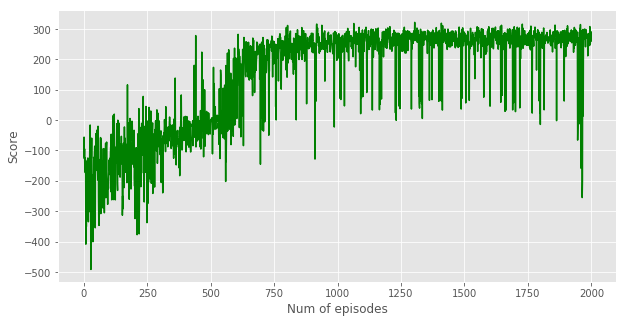

In [22]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(scores)), scores, color='green')
plt.xlabel('Num of episodes')
plt.ylabel('Score')
if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/plot_of_agent_evaluation.png')
plt.show()

## Watch The Smart Agent

In [24]:
# load the weights of smart agent
agent.dqn_net.load_state_dict(torch.load(f'./agents/DQN_{ENV_NAME}.pth'));

In [27]:
num_of_episodes = 20

for i_episode in range(1, num_of_episodes+1):
    
    state = env.reset()
    for time_step in range(200):
        
        # select an action
        action = agent.act(state)
        env.render()
        
        next_state, reward, done, _ = env.step(action)
        state = next_state
        if done:
            break

env.close()

---